<blockquote>
    <h1>Exercise 8.8</h1>
    <p>In the lab, a classification tree was applied to the <code>Carseats</code> data set after converting $\mathrm{Sales}$ into a qualitative response variable. Now we will seek to predict $\mathrm{Sales}$ using regression trees and related approaches, treating the response as a quantitative variable.</p>
    <ol>
        <li>Split the data set into a training set and a test set.</li>
        <li>Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?</li>
        <li>Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?</li>
        <li>Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the <code>importance()</code> function to determine which variables are most important.</li>
        <li>Use random forests to analyze this data. What test MSE do you obtain? Use the <code>importance()</code> function to determine which variables are most important. Describe the effect of $m$, the number of variables considered at each split, on the error rate obtained.</li>
    </ol>
</blockquote>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from ipywidgets import interactive  # https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084
from IPython.display import display
from IPython.display import SVG
from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.preprocessing import OneHotEncoder  # https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("../../DataSets/Carseats/Carseats.csv")
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [3]:
# Convert categorical data using one hot encoding:
# which takes a column with categorical data and 
# then splits the column into multiple columns. 
# The numbers are replaced by 1s and 0s, depending 
# on which column has what value. 
categorical_lst = ['ShelveLoc', 'US', 'Urban']
columns = df.columns.tolist()
indices = [index for index, column in enumerate(columns) if column in categorical_lst]

onehotencoder = OneHotEncoder()
categorical_transformed = onehotencoder.fit_transform(df[categorical_lst]).toarray()
    
new_categorical_lst = []
for categorical_name, np_arr in zip(categorical_lst, onehotencoder.categories_):
    temp_lst = [f'{categorical_name} ({category})' for category in np_arr]
    new_categorical_lst.extend(temp_lst)
    
df_categorical_transformed = pd.DataFrame(categorical_transformed, columns=new_categorical_lst, dtype='int64')
for column in new_categorical_lst:
    df_categorical_transformed[column] = df_categorical_transformed[column].astype('category')

df_transformed = pd.concat([df.drop(categorical_lst, 1), df_categorical_transformed], axis=1)
df_transformed.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc (Bad),ShelveLoc (Good),ShelveLoc (Medium),US (No),US (Yes),Urban (No),Urban (Yes)
0,9.50,138,73,11,276,120,42,17,1,0,0,0,1,0,1
1,11.22,111,48,16,260,83,65,10,0,1,0,0,1,0,1
2,10.06,113,35,10,269,80,59,12,0,0,1,0,1,0,1
3,7.40,117,100,4,466,97,55,14,0,0,1,0,1,0,1
4,4.15,141,64,3,340,128,38,13,1,0,0,1,0,0,1


In [4]:
# https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084
# Interactive Visualization of Decision Trees with Jupyter Widgets

def plot_tree(splitter, max_depth, min_samples_split, min_samples_leaf=0.2):
    tree_reg = DecisionTreeRegressor(
        criterion='mse',
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    tree_reg.fit(df_transformed.drop('Sales', 1), df_transformed[['Sales']])
    
    graph = Source(export_graphviz(
        tree_reg,
        out_file=None,
        feature_names=df_transformed.drop('Sales', 1).columns.tolist(),
        rounded=True,
        filled=True
    ))
   
    display(SVG(graph.pipe(format='svg')))
    return tree_reg

inter = interactive(
    plot_tree,
    splitter=['best', 'random'],
    max_depth=[1, 2, 3, 4],
    min_samples_split=(0.1, 1),
    min_samples_leaf=(0.1, 0.5)
)

display(inter)

interactive(children=(Dropdown(description='splitter', options=('best', 'random'), value='best'), Dropdown(des…

<h3>Exercise 8.8.1</h3>
<blockquote>
    <i>Split the data set into a training set and a test set.</i>
</blockquote>

In [5]:
df_y = df_transformed[['Sales']]
df_x = df_transformed.drop('Sales', 1)
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    df_x, 
    df_y, 
    test_size=0.2, 
    random_state=42
)

<h3>Exercise 8.8.2</h3>
<blockquote>
    <i>Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?</i>
</blockquote>

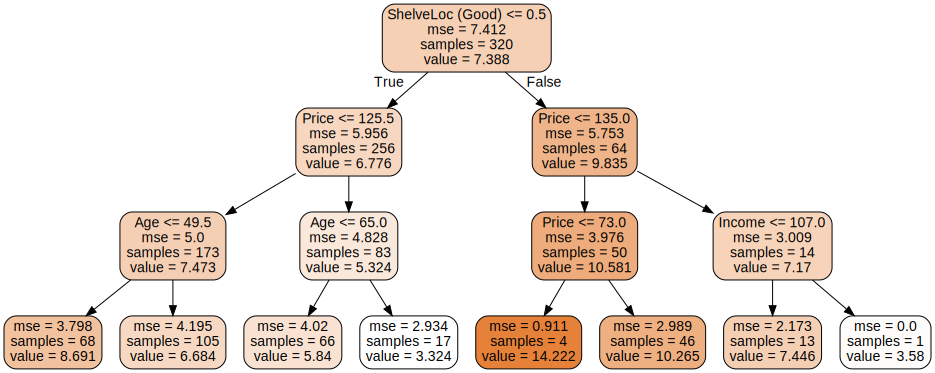

In [6]:
tree_reg = DecisionTreeRegressor(
    criterion='mse', 
    splitter='best', 
    max_depth=3,
    random_state=42
)
_ = tree_reg.fit(df_x_train, df_y_train)

transformed_columns_lst = df_x.columns.tolist()
graph = Source(export_graphviz(
    tree_reg, 
    out_file=None,
    feature_names=transformed_columns_lst,
    rounded=True,
    filled=True
))

display(SVG(graph.pipe(format='svg')))

In [7]:
y_pred = tree_reg.predict(df_x_test)
MSE = mean_squared_error(y_pred, df_y_test)
print(f'test MSE = {MSE:.2f}')

test MSE = 6.68


<h3>Exercise 8.8.3</h3>
<blockquote>
    <i>Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?</i>
</blockquote>

In [8]:
best_MSE = float('+inf')
best_complexity = None
for splitter in ['best', 'random']:
    for depth in range(1, 5):
        for samples_split in [i/10 for i in range(1, 11)]:
            for samples_leaf in [i/10 for i in range(1, 6)]:
                MSE = 0
                tree_reg = DecisionTreeRegressor(
                    criterion='mse', 
                    splitter=splitter, 
                    max_depth=depth,
                    min_samples_split=samples_split,
                    min_samples_leaf=samples_leaf,
                    random_state=42
                )
                _ = tree_reg.fit(df_x_train, df_y_train)

                y_pred = tree_reg.predict(df_x_test)
                MSE = mean_squared_error(y_pred, df_y_test)
                if MSE < best_MSE:
                    best_MSE = MSE
                    best_complexity = (splitter, depth, samples_split, samples_leaf)
                    
print(f'smallest MSE = {best_MSE:.2f}')
print(f'splitter, depth, samples_split, best_samples_leaf = {best_complexity}')

smallest MSE = 5.28
splitter, depth, samples_split, best_samples_leaf = ('random', 4, 0.1, 0.1)


<h3>Exercise 8.8.4</h3>
<blockquote>
    <i>Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the <code>importance()</code> function to determine which variables are most important.</i>
</blockquote>

In [9]:
tree_reg = DecisionTreeRegressor(
    criterion='mse', 
    splitter='best', 
    max_depth=3,
    random_state=42
)
_ = tree_reg.fit(df_x_train, df_y_train)

number_of_trees = 500
sample_size = df_x_train.shape[0]
bag = BaggingRegressor(
    DecisionTreeRegressor(
        criterion='mse', 
        splitter='best', 
        max_depth=3,
        random_state=42
    ),
    oob_score=True,
    n_estimators=number_of_trees,
    max_samples=sample_size,
    bootstrap=True,
    n_jobs=-1
)

_ = bag.fit(df_x_train, df_y_train.squeeze())
Y_oob_pred = bag.oob_prediction_
MSE_oob = mean_squared_error(Y_oob_pred, df_y_train)
print(f'out-of-bag MSE = {MSE_oob:.2f}')

y_pred = bag.predict(df_x_test)
MSE = mean_squared_error(y_pred, df_y_test)
print(f'test MSE = {MSE:.2f}')

out-of-bag MSE = 3.75
test MSE = 4.36


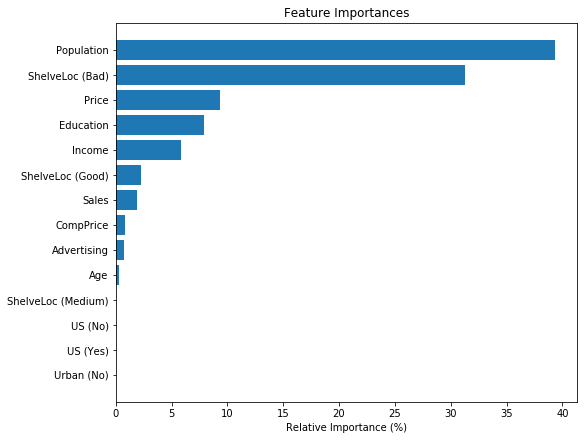

In [10]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in bag.estimators_
], axis=0)


importances = 100 * feature_importances
indices = np.argsort(importances)
columns = df_transformed.columns.tolist()

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6))

_ = ax.barh(range(len(indices)), importances[indices], align='center')
# _ = ax.set_yticks(range(len(indices)), [columns[i] for i in indices])
_ = ax.set_yticklabels([columns[i] for i in indices])
_ = ax.set_yticks(range(len(indices)))
_ = ax.set_xlabel('Relative Importance (%)')
_ = ax.set_title('Feature Importances')

<h3>Exercise 8.8.5</h3>
<blockquote>
    <i>Use random forests to analyze this data. What test MSE do you obtain? Use the <code>importance()</code> function to determine which variables are most important. Describe the effect of $m$, the number of variables considered at each split, on the error rate obtained.</i>
</blockquote>

In [11]:
best_MSE = float('+inf')
best_complexity = None
max_features = df_x_train.shape[1]
for depth in range(1, 5):
    for features in range(1, max_features):
        rnd_clf = RandomForestRegressor(
            n_estimators=number_of_trees, 
            max_features=features, 
            max_depth=depth,
            bootstrap=True, 
            random_state=42, 
            n_jobs=11
        )
        _ = rnd_clf.fit(df_x_train, df_y_train.squeeze())

        y_pred = rnd_clf.predict(df_x_test)
        MSE = mean_squared_error(y_pred, df_y_test)
        if MSE < best_MSE:
            best_MSE = MSE
            best_complexity = (depth, features)

print(f'smallest MSE = {best_MSE:.2f}')
print(f'splitter, depth, samples_split, best_samples_leaf = {best_complexity}')

smallest MSE = 3.83
splitter, depth, samples_split, best_samples_leaf = (4, 10)


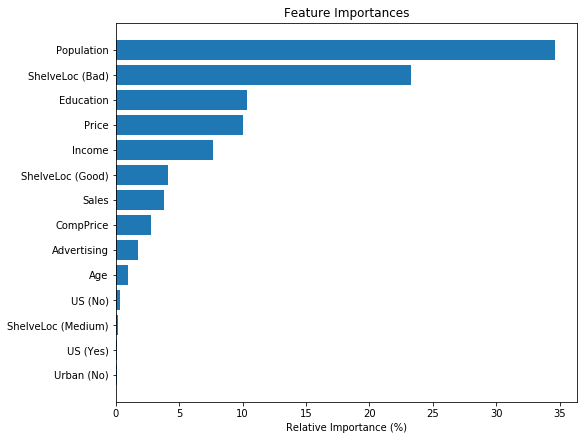

In [12]:
best_depth, best_features = best_complexity

rnd_clf = RandomForestRegressor(
    n_estimators=number_of_trees, 
    max_features=best_features, 
    max_depth=best_depth,
    oob_score=True,
    bootstrap=True, 
    random_state=42, 
    n_jobs=11
)
_ = rnd_clf.fit(df_x_train, df_y_train.squeeze())

importances = 100 * rnd_clf.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6))

_ = ax.barh(range(len(indices)), importances[indices], align='center')
# _ = ax.set_yticks(range(len(indices)), [columns[i] for i in indices])
_ = ax.set_yticklabels([columns[i] for i in indices])
_ = ax.set_yticks(range(len(indices)))
_ = ax.set_xlabel('Relative Importance (%)')
_ = ax.set_title('Feature Importances')

In [13]:
result = {}
for features in range(1, max_features):
    rnd_clf = RandomForestRegressor(
        n_estimators=number_of_trees, 
        max_features=features, 
        max_depth=best_depth,
        bootstrap=True, 
        random_state=42, 
        n_jobs=11
    )
    _ = rnd_clf.fit(df_x_train, df_y_train.squeeze())

    y_pred = rnd_clf.predict(df_x_test)
    MSE = mean_squared_error(y_pred, df_y_test)
    result[features] = MSE

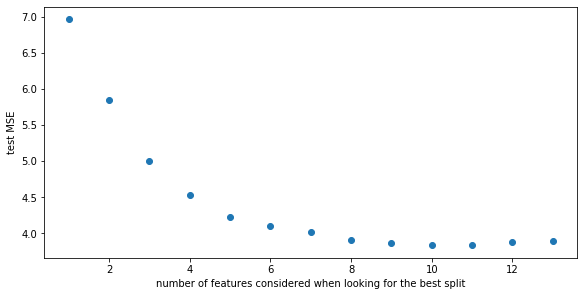

In [14]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 4))
_ = ax.scatter(result.keys(), result.values())
_ = ax.set_xlabel('number of features considered when looking for the best split')
_ = ax.set_ylabel('test MSE')